# GDF+PCA+MLP results for all 10000 stocks

As features for MLP we use reduced GDF (all 50) + Queue Imbalance + Previous Queue Imbalance reduced using PCA to 10 components. We are prediciting Mid-Price Indicator.

## Hyperparameters for MLP

* r - parameter for GDF
* s - parameter for GDF
* alpha - L2 penalty parameter from set $ [1.0, 0.1, 0.01, 0.0001, 0.001]$
* hidden_layer_size - number of hidden layers from set ${(8, 8), (8, 16), (8), (16), (16, 16), (16, 8)}$
* activation function - tanh
* solver - adam

## Validation
We used 10-fold forward anchored cross validation

We measure MCC (Matthews Correlation Coefficient) and ROC area score. Choice of best classifier is done using MCC instead of ROC area score, since MCC is not prone to class imbalance issues (different amounts of positives and negatives in data set). Of course for most of the stocks we observed that classes are usually balanced. But also usually classifier with highest MCC score on validation set has also the highest ROC area score.

We compare approach GDF+PCA+MLP with Logistic Regression on Queue Imbalance feature (LR+QUE).

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, roc_results
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
rs_params = [(0.1, 1.0), (1.0, 0.1), (1.0, 1.0), (0.1, 0.1), (0.01, 1.0), (0.01, 0.1)]
stocks = list(roc_results.result_cv_10000.keys())
data_dir = 'res_mlp_pca_gdf_que_prev10'

In [3]:
def get_mean_scores(scores: dict) -> dict:
    mean_scores = {}
    for k, v in scores.items():
        mean_scores[k] = np.mean(v)
    return mean_scores

def get_score_for_clf(clf, df_test):
    x_test = df_test[['queue_imbalance']]
    y_test = df_test['mid_price_indicator'].values
    return model.test_model(clf, x_test, y_test)

def get_logistic_regression(stock, data_length):
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)
    clf = LogisticRegression()
    train_x = df[['queue_imbalance']]

    scores = model.validate_model(clf, train_x, df['mid_price_indicator'], folds=2)
    res = {
        **get_mean_scores(scores),
        'stock': stock,
        'kernel': 'logistic',
    }
    test_scores = get_score_for_clf(clf, df_test)
    return {**res, **test_scores}

In [4]:
df_res = pd.DataFrame()
for stock in stocks:
    for r, s in rs_params:
        filename = data_dir + '/mlp_pca_gdf_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s)
        if os.path.exists(filename):
            df_temp = pd.read_csv(filename)
            df_temp['r'] = [r] * len(df_temp)
            df_temp['s'] = [s] * len(df_temp)
            df_res = df_res.append(df_temp)
columns = ['stock', 'hidden_layer_sizes', 
           'matthews', 'roc_auc',  'test_matthews', 'test_roc_auc', 'r', 's']
df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1).head(5)

,stock,hidden_layer_sizes,matthews,roc_auc,test_matthews,test_roc_auc,r,s
12,11946,"(8, 16)",0.193830,0.595376,0.201930,0.599834,0.10,0.1
4,3879,"(8, 16)",0.176045,0.587324,0.099171,0.549295,0.10,0.1
14,7858,"(16, 8)",0.174937,0.586756,0.138448,0.564298,0.10,1.0
8,4320,"(8, 16)",0.170416,0.584709,0.161428,0.580071,0.01,1.0
4,3035,"(8, 16)",0.170008,0.584310,0.101339,0.550399,0.10,1.0


Above we see a few results for the best MLP classifiers (sorted by MCC validation score `matthews`). The results are not perfect - for sure for some of them we are overfitting (f.e. 3879 difference between validation and test scores is big).

In [5]:
df_gdf_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_gdf_best['stock'] = df_gdf_best['stock'].values.astype(np.int)
df_gdf_best.index = df_gdf_best['stock'].values.astype(np.int)

Text(0.5,1,'MCC score distribution for different r and s parameters for validation set')

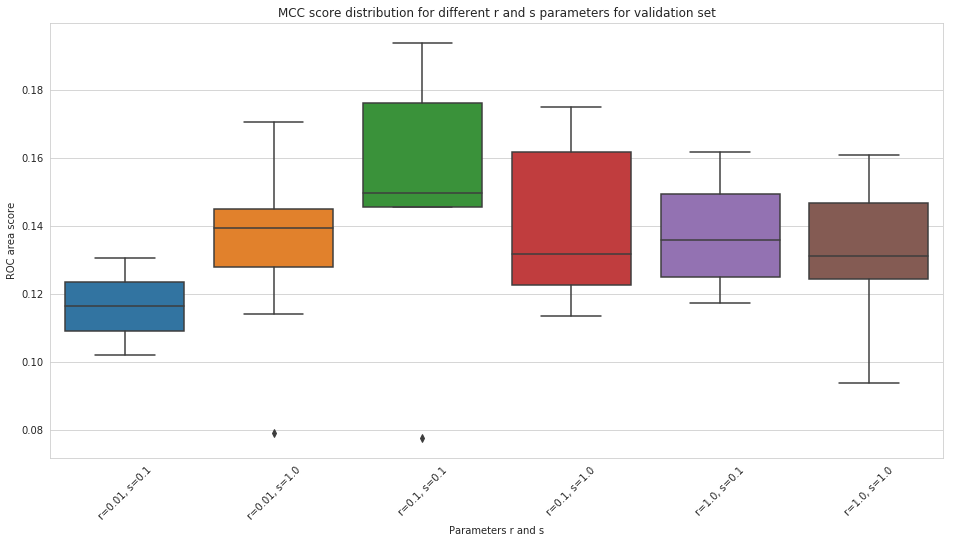

In [6]:
r_s_dict = OrderedDict()
r_parameters = [0.01, 0.1, 1.0]
s_parameters = [0.1, 1.0]
for r in r_parameters:
    for s in s_parameters:
        r_s_dict[
            'r={}, s={}'.format(r, s)] = df_gdf_best[df_gdf_best['r'] == r][df_gdf_best['s'] == s][
            'matthews'].values

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=list(r_s_dict.values()))
plt.ylabel('ROC area score')
plt.xlabel('Parameters r and s')
_ = ax.set_xticklabels(list(r_s_dict.keys()), rotation=45)
plt.title('MCC score distribution for different r and s parameters for validation set')

In [7]:
log_res = []
for stock in stocks:
    log_res.append(get_logistic_regression(stock, data_length))
df_log_res = pd.DataFrame(log_res)
df_log_res['stock'] = df_log_res['stock'].values.astype(np.int)
df_log_res.index = df_log_res['stock'].values.astype(np.int)
df_all = pd.merge(df_gdf_best, df_log_res, on='stock', suffixes=['_mlp', '_log'])
df_all['matthews_diff'] = df_all['matthews_mlp'] -  df_all['matthews_log']
df_all['matthews_test_diff'] = df_all['test_matthews_mlp'] - df_all['test_matthews_log']
all_columns = ['matthews_mlp', 'matthews_log',  'test_matthews_mlp','test_matthews_log', 
       'roc_auc_mlp', 'roc_auc_log', 'test_roc_auc_mlp',  'test_roc_auc_log', 'stock',
              'matthews_diff', 'matthews_test_diff']

df_all[all_columns].head()

,matthews_mlp,matthews_log,test_matthews_mlp,test_matthews_log,roc_auc_mlp,roc_auc_log,test_roc_auc_mlp,test_roc_auc_log,stock,matthews_diff,matthews_test_diff
0,0.193830,0.195228,0.201930,0.207584,0.595376,0.597678,0.599834,0.603555,11946,-0.001398,-0.005654
1,0.176045,0.156645,0.099171,0.109705,0.587324,0.577662,0.549295,0.554478,3879,0.019400,-0.010534
2,0.174937,0.153560,0.138448,0.171398,0.586756,0.576792,0.564298,0.584732,7858,0.021377,-0.032950
3,0.170416,0.186482,0.161428,0.154918,0.584709,0.592922,0.580071,0.577343,4320,-0.016067,0.006510
4,0.170008,0.180586,0.101339,0.097073,0.584310,0.590223,0.550399,0.548374,3035,-0.010579,0.004266


Above we have LR+QUE scores combined with GDF+PCA+MLP.

Median of difference of MCC scores on validation and testing set
0.008455976615747068 0.00290996036730988
Mean of difference of MCC scores on validation and testing set
0.007842720291149779 0.002889854915793175


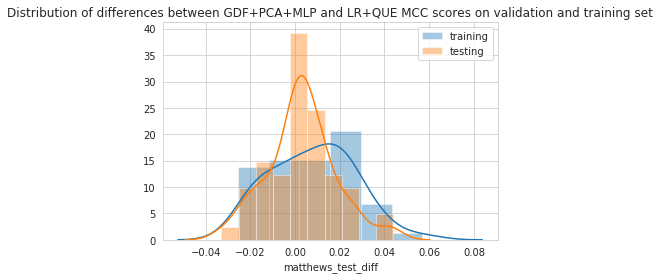

In [8]:
sns.distplot(df_all['matthews_diff'], label='training')
sns.distplot(df_all['matthews_test_diff'], label='testing')
plt.legend()
plt.title('Distribution of differences between GDF+PCA+MLP and LR+QUE MCC scores on validation and training set')

print('Median of difference of MCC scores on validation and testing set')
print(df_all['matthews_diff'].median(), df_all['matthews_test_diff'].median())
print('Mean of difference of MCC scores on validation and testing set')
print(df_all['matthews_diff'].mean(), df_all['matthews_test_diff'].mean())

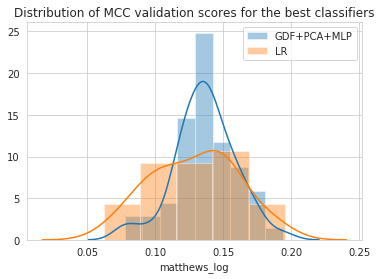

In [9]:
sns.distplot(df_all['matthews_mlp'], label='GDF+PCA+MLP')
sns.distplot(df_all['matthews_log'], label='LR')
plt.title('Distribution of MCC validation scores for the best classifiers')
plt.legend()

In [10]:
print('Number of better stocks for which we got better results using MLP+PCA+GDF approach'
      'than for Logistic Regression with Queue Imbalance:')

print('validation set', len(df_all[df_all['matthews_mlp'] > df_all['matthews_log']][all_columns]))
print('test_set', len(df_all[df_all['test_matthews_mlp'] > df_all['test_matthews_log']]))
print('total number of stocks', len(df_all))

Number of better stocks for which we got better results using MLP+PCA+GDF approachthan for Logistic Regression with Queue Imbalance:
validation set 34
test_set 33
total number of stocks 53


Median of difference for stocks which were worse for MLP than LR+QUE


-0.010984430938083045

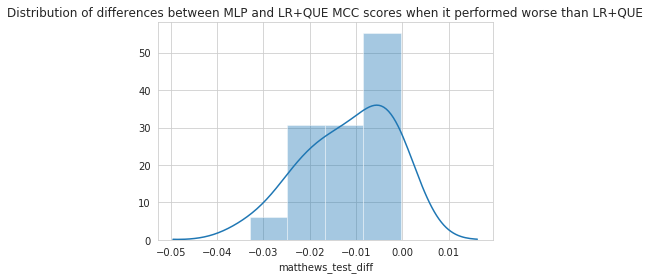

In [11]:
sns.distplot(df_all[df_all['test_matthews_mlp'] < df_all['test_matthews_log']]['matthews_test_diff'])
plt.title('Distribution of differences between MLP and LR+QUE MCC scores when it performed worse than LR+QUE')
print('Median of difference for stocks which were worse for MLP than LR+QUE')
df_all[df_all['test_matthews_mlp'] < df_all['test_matthews_log']]['matthews_test_diff'].median()

In [12]:
print('Number of better stocks for which we got better scores using ROC Area score using MLP+PCA+GDF approach'
      'than for Logistic Regression with Queue Imbalance:')

print('validation set', len(df_all[df_all['roc_auc_mlp'] > df_all['roc_auc_log']][all_columns]))
print('test_set', len(df_all[df_all['test_roc_auc_mlp'] > df_all['test_roc_auc_log']]))
print('total number of stocks', len(df_all))

Number of better stocks for which we got better scores using ROC Area score using MLP+PCA+GDF approachthan for Logistic Regression with Queue Imbalance:
validation set 34
test_set 29
total number of stocks 53


In [13]:
df_all[df_all['test_matthews_mlp'] < df_all['test_matthews_log']][all_columns].head()

,matthews_mlp,matthews_log,test_matthews_mlp,test_matthews_log,roc_auc_mlp,roc_auc_log,test_roc_auc_mlp,test_roc_auc_log,stock,matthews_diff,matthews_test_diff
0,0.193830,0.195228,0.201930,0.207584,0.595376,0.597678,0.599834,0.603555,11946,-0.001398,-0.005654
1,0.176045,0.156645,0.099171,0.109705,0.587324,0.577662,0.549295,0.554478,3879,0.019400,-0.010534
2,0.174937,0.153560,0.138448,0.171398,0.586756,0.576792,0.564298,0.584732,7858,0.021377,-0.032950
5,0.161776,0.144501,0.118693,0.123164,0.578453,0.570231,0.556268,0.557401,1472,0.017275,-0.004471
12,0.150362,0.156086,0.141941,0.143297,0.574519,0.577835,0.570933,0.571621,11869,-0.005724,-0.001356


In [14]:
df_all[df_all['test_roc_auc_mlp'] < df_all['test_roc_auc_log']][all_columns].head()

,matthews_mlp,matthews_log,test_matthews_mlp,test_matthews_log,roc_auc_mlp,roc_auc_log,test_roc_auc_mlp,test_roc_auc_log,stock,matthews_diff,matthews_test_diff
0,0.193830,0.195228,0.201930,0.207584,0.595376,0.597678,0.599834,0.603555,11946,-0.001398,-0.005654
1,0.176045,0.156645,0.099171,0.109705,0.587324,0.577662,0.549295,0.554478,3879,0.019400,-0.010534
2,0.174937,0.153560,0.138448,0.171398,0.586756,0.576792,0.564298,0.584732,7858,0.021377,-0.032950
5,0.161776,0.144501,0.118693,0.123164,0.578453,0.570231,0.556268,0.557401,1472,0.017275,-0.004471
7,0.159369,0.176488,0.111070,0.110441,0.578566,0.588278,0.555151,0.555225,10484,-0.017119,0.000629


## Conclusion

A bit of further hyper-parameter tuning for some stocks will be needed, because it is possible that we are overfitting. Still GDF+PCA+MLP approach performs better for more than half of the stocks. We didn't try many hyper-parameters.